In [1]:
import lightkurve as lk
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
df = pd.read_csv('/Users/tuca/Desktop/EPIC_exoplanet_research_2023/detrended_lc.csv', header = 0,
                 names = ['time', 'flux', 'unknown', 'Kepler'])
df

,time,flux,unknown,Kepler
0,2.457218e+06,0.999964,0.000349,Kepler
1,2.457218e+06,0.999885,0.000349,Kepler
2,2.457218e+06,0.999775,0.000350,Kepler
3,2.457218e+06,1.000145,0.000350,Kepler
4,2.457218e+06,1.000182,0.000350,Kepler
...,...,...,...,...
6774,2.458247e+06,1.000329,0.000256,Kepler
6775,2.458247e+06,0.999761,0.000256,Kepler
6776,2.458247e+06,0.999960,0.000256,Kepler
6777,2.458247e+06,0.999999,0.000256,Kepler


In [3]:
time = df['time'] - 2454833
flux = df['flux']
unknown = df['unknown']

2384.503430427052


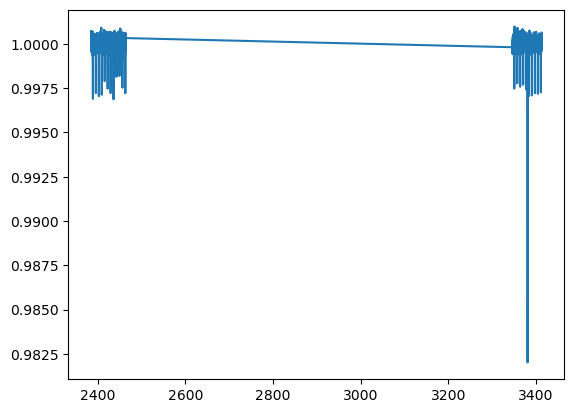

In [4]:
plt.plot(time, flux)
print(np.min(time))
# plt.xlim(2300, 2500)
# plt.ylim(0.9975, 1.0)

In [19]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

In [25]:

periods = [6.7252337648, 1e3]
period_error = [0.1, 1e3]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833]
t0_error = [0.1, 0.2]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
ecc_fit = False

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((constants.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (constants.R_sun).to(u.au).value
print(Rsun2Rearth)
print(u.M_earth)
#pdb.set_trace()

# with pm.Model() as model:

#     mean = pm.Normal("mean", mu=0.0, sigma=10.0)
#     u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
#     # Stellar parameters
#     #pdb.set_trace()
#     BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
#     m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
#     r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
#     teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
#     st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity
#     star_params = [mean, u]
    
#     # Planet parameters
#     ror = pm.Uniform("ror", lower=0, upper = 1, shape=nplanets, testval=np.array([0.04, 0.06]))
#     r_pl = pm.Deterministic("r_pl", ror*r_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
#     m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e6, testval=Expected_msini, shape=nplanets)
#     # deterministic means values that were derived from the model
#     density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3

#     # Orbital parameters
#     # 'log period' is normally used when you dont know the period of the planet 
# #     log_period = pm.Normal("log_period", mu=np.log(periods), sigma=1.0, shape = nplanets) #free parameter is log period
# #     period = pm.Deterministic("period", tt.exp(log_period))
# #     t0 = pm.Normal("t0", mu=t0s, sigma=1.0, shape = 2)
# #     log_dur = pm.Normal("log_dur", mu=np.log(duration), sigma=10.0, shape = nplanets)
# #     dur = pm.Deterministic("dur", tt.exp(log_dur))
#     period = pm.Normal("period", mu=periods, sigma= np.array(period_error), shape=nplanets)
#     t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_error), shape=nplanets)
#     b = xo.distributions.ImpactParameter("b", ror=ror, shape=nplanets)
    
#     # Set up the orbit
#     #orbit = xo.orbits.KeplerianOrbit(period=period, ror = ror, duration=dur, t0=t0, b=b)

#     if ecc_fit:
#         # for an eccentric orbit # 
#         ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
#         ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
#         omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
#     else:
#         # for circular orbit #
#         ecc = np.repeat(0, nplanets)
#         omega = np.repeat(np.pi/2, nplanets)

#         # Orbit model
#         orbit = xo.orbits.KeplerianOrbit(r_star = R_star, m_star= M_star, period = periods, t0 = t0s, b = b, 
#                                          m_planet = xo.units.with_unit(m_pl, u.M_earth), ecc = ecc, omega = omega)
    
#     # Set up the mean transit model
#     star = xo.LimbDarkLightCurve(u)
#     lc_model = mean + 1e3 * tt.sum(
#         star.get_light_curve(orbit=orbit, r=r_pl, t=time), axis=-1
#     )
    
#     map_soln = model.test_point
#     map_soln = pmx.optimize(map_soln)
#     map_soln = pmx.optimize(map_soln, [r_pl, b, dur])
#     map_soln = pmx.optimize(map_soln, star_params)


#     ####################################################################################  
    

109.07637070600963
earthMass


In [ ]:
#     # The baseline flux
#     mean = pm.Normal("mean", mu=0.0, sd=10.0)

#     # The time of a reference transit for each planet
#     t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

#     # The log period; also tracking the period itself
#     logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
#     period = pm.Deterministic("period", pm.math.exp(logP))

#     # The Kipping (2013) parameterization for quadratic limb darkening paramters
#     # Stellar Parameters
#     u = xo.distributions.QuadLimbDark("u")

#     r = pm.Uniform("r", lower=0.01, upper=0.1, shape=2)
    
#     b = xo.distributions.ImpactParameter(
#         "b", ror=r, shape=2)


#     # Set up a Keplerian orbit for the planets
#     orbit = xo.orbits.KeplerianOrbit(period=period, t=t0, b=b)

#     # Compute the model light curve using starry
#     light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
#         orbit=orbit, r=r, t=time
#     )
#     light_curve = pm.math.sum(light_curves, axis=-1) + mean
#     lc_model = mean + 1e3 * tt.sum(
#         light_curves.get_light_curve(orbit=orbit, r=ror, t=x), axis=-1
#     )

#     # Here we track the value of the model light curve for plotting
#     # purposes
#     pm.Deterministic("light_curves", light_curves)

#     # Fit for the maximum a posteriori parameters given the simuated
#     # dataset
# #     map_soln = pmx.optimize(start=model.test_point)
#     print(model.check_test_point())

In [ ]:
with model:
    lc_pred = pmx.eval_in_model(lc_model, map_soln)
    #gp_pred = pmx.eval_in_model(gp.predict(y - lc_pred), map_soln)

plt.figure(figsize=(8, 4))
x_fold = (time - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
    "period"
] - 0.5 * map_soln["period"]
inds = np.argsort(x_fold)
plt.scatter(x_fold, y - gp_pred - map_soln["mean"], c=time, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

In [ ]:
# ##### Planet 1 has t0 = 2457221.8349184883, per = 6.7252337648 days, duration of 0.9 hours. #####
# #### Planet 2 has t0 = 2458213.8222186137, duration of 15.71 hours and an unknown ####
# ##### period (so you can use per = 1000 when searching for all events). ######

# ###Using the EVEREST pipeline (K2/Campaign 17) ###

# #def mask_outliers(min_time, flux, flux_err, period = None, transit_time = None, duration = None):
# plt.rcParams['figure.figsize'] = [10, 5]
# lc = flux
# def mask_outliers(period, transit_time, duration):

#     mask_transit_1 = lc.create_transit_mask(period = period, transit_time = transit_time, duration = duration)
#     mask_transit_2 = lc.create_transit_mask(period = period, transit_time = transit_time, duration = duration)
#     mask_transit = mask_transit_1 | mask_transit_2
    
#     ### Numpy function that will return the NOT elements of mask_transit
#     ### Note: This is a logical function that computes the truth value of NOT arr element-wise ###
#     mask_out_transit = np.logical_not(mask_transit_1 | mask_transit_2)
    
#     ### Function that removes outliers in the data ###
#     mask_outliers = lc.remove_outliers(sigma_lower=10, sigma_upper=3)
    
#     #plotting the raw data out of transit data
#     plt.plot(lc.time.value[mask_out_transit], (lc.flux.value/np.median(lc.flux.value))[mask_out_transit], 
#                           'r.', linestyle='none', zorder = 0)
#     #plotting the mask_outliers function
#     plt.plot(mask_outliers.time.value, (mask_outliers.flux.value/np.median(mask_outliers.flux.value)), 
#                           'k.', linestyle='none', zorder = 10)
#     #plotting the in-transit points
#     plt.plot(lc.time.value[mask_transit], (lc.flux.value/np.median(lc.flux.value))[mask_transit], 
#                           'g.', linestyle='none', zorder = 2)

#     return mask_outliers
    
#     ### Note: The lightkurve function 'remove_outliers' by default uses np.median ###
#     ### and Caleb recommends to use a rolling median instead ###

#     ### To do:
#     ### 1. Modify this function by adding a mask and rolling median or wotan
#     ### 2. Try plotting TOI-1728

In [ ]:
# ### Calling the above function ###
# mask_outliers(period = [6.7252337648, 1e4], transit_time = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833], 
#               duration = [0.9/24, 15.71/24])
# #plt.xlim(3380, 3382)
# plt.ylim(0.98,1.01)